Loading the processed Zarr dataset for a quick check...

--- Value Range Check After Clipping ---
Minimum value: 0.0
Maximum value: 1.0

Creating a Cartopy plot for 2010-01-20...


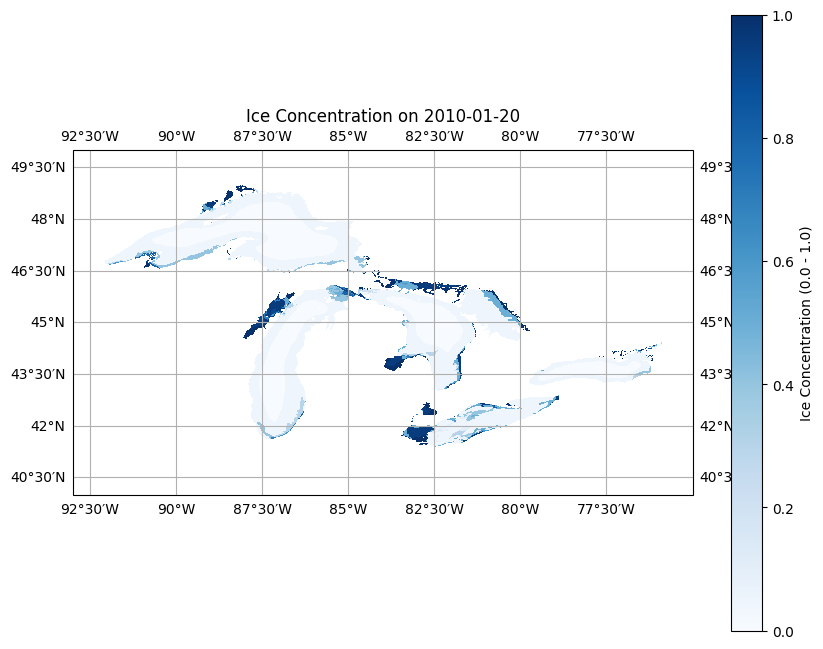


--- Final Dataset Information ---
<xarray.Dataset> Size: 40GB
Dimensions:            (time: 10221, lat: 838, lon: 1181)
Coordinates:
  * lat                (lat) float64 7kB 38.87 38.89 38.9 ... 50.58 50.59 50.61
  * lon                (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.9 -75.88
  * time               (time) datetime64[ns] 82kB 1995-01-01 ... 2022-12-31
Data variables:
    ice_concentration  (time, lat, lon) float32 40GB dask.array<chunksize=(366, 200, 200), meta=np.ndarray>
Attributes: (12/24)
    coverage_area:            Great Lakes
    data_source:              NOAA
    description:              Great Lakes ice concentrations
    disclaimer:               Data collected and processed by NOAA and dissem...
    dissemination:            USNIC Website, CIS Website
    grid_resolution:          1.800 km
    ...                       ...
    source:                   NAIS daily Great Lakes ice analysis
    source_url:               https://noaadata.apps.nsidc.org/NOAA/G1002

In [1]:
# Import necessary libraries
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Define the path to your new, processed Zarr store
processed_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/NSIDC/ice_concentration_interp_on_glsea_grid.zarr'

# Load the dataset
print("Loading the processed Zarr dataset for a quick check...")
try:
    ds = xr.open_zarr(processed_path)
except FileNotFoundError:
    print(f"Error: The file was not found at {processed_path}. Please check the path.")
    exit()

# 1. Sanity Check
# Clip the data to ensure all values are between 0 and 1
# This is a good practice to handle any small floating-point errors from interpolation.
ds_clipped = ds.clip(min=0.0, max=1.0)

# Check the value range after clipping
print("\n--- Value Range Check After Clipping ---")
min_val = ds_clipped['ice_concentration'].min().values
max_val = ds_clipped['ice_concentration'].max().values
print(f"Minimum value: {min_val}")
print(f"Maximum value: {max_val}")

# 2. Plotting
# Select a single time slice for a deep winter month to plot, e.g., Jan 20, 2010
time_slice = ds_clipped.sel(time='2010-01-20', method='nearest')

print(f"\nCreating a Cartopy plot for {str(time_slice.time.values)[:10]}...")

# Set up the figure and axes with a Plate Carree projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-93, -75, 40, 50], crs=ccrs.PlateCarree())

# Plot the ice concentration data
ice_conc_plot = time_slice.ice_concentration.plot(
    ax=ax,
    x='lon',
    y='lat',
    transform=ccrs.PlateCarree(),
    cmap='Blues',
    robust=True, # Automatically exclude extreme outliers from color scaling
    cbar_kwargs={'label': 'Ice Concentration (0.0 - 1.0)'}
)

# Add geographical features for context
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.set_title(f"Ice Concentration on {str(time_slice.time.values)[:10]}")

plt.show()

# 3. Final Checks (optional, for reassurance)
print("\n--- Final Dataset Information ---")
print(ds_clipped)
